In [1]:
import numpy as np
import pandas as pd

from mplchart.samples import sample_prices   


In [2]:
prices = sample_prices()
prices

,open,high,low,close,volume
date,,,,,
1980-12-12,0.098389,0.098817,0.098389,0.098389,469033600
1980-12-15,0.093684,0.093684,0.093256,0.093256,175884800
1980-12-16,0.086839,0.086839,0.086412,0.086412,105728000
1980-12-17,0.088550,0.088978,0.088550,0.088550,86441600
1980-12-18,0.091118,0.091545,0.091118,0.091118,73449600
...,...,...,...,...,...
2025-11-11,269.809998,275.910004,269.799988,275.250000,46208300
2025-11-12,275.000000,275.730011,271.700012,273.470001,48398000
2025-11-13,274.109985,276.700012,272.089996,272.950012,49602800


In [3]:
""" Parabolic Stop and Reverse """


def calc_sar(prices, afs: float=0.02, maxaf: float=0.2):
    """
    Parabolic Stop and Reverse
    
    Args:
        afs (float) : starting acceleration factor, default 0.02
        maxaf (float) : maximum acceleration factor, default 0.2
    """

    data = prices[['high', 'low']].values
    size = data.shape[0]
    output = np.full(size, np.nan)

    ep = sar = af = trend = np.nan
    ph = pl = hi = lo = np.nan

    for i in range(size):
        if hi >= lo:
            ph, pl = hi, lo

        hi, lo = data[i]

        if not (hi >= lo and ph >= pl):
            continue

        hi2 = ph if ph > hi else hi
        lo2 = pl if pl < lo else lo

        # check for reversal
        if trend > 0 and lo < sar:
            ep, sar, af, trend = lo, ep, afs, -1

        elif trend < 0 and hi > sar:
            ep, sar, af, trend = hi, ep, afs, +1

        output[i] = sar

        # calculate next sar
        if trend != trend:
            # initialize sar
            if hi > ph:
                ep, sar, af, trend = hi2, lo2, afs, +1
            else:
                ep, sar, af, trend = lo2, hi2, afs, -1
        else:
            # update sar
            sar += af * (ep - sar)
            # adjust sar, ep, af if needed
            if trend > 0:
                if lo2 < sar:
                    sar = lo2
                if hi > ep:
                    ep = hi
                    af += afs
            if trend < 0:
                if hi2 > sar:
                    sar = hi2
                if lo < ep:
                    ep = lo
                    af += afs

        if maxaf and af > maxaf:
            af = maxaf

    result = pd.Series(output, index=prices.index)

    return result





In [4]:
calc_sar(prices)

date
1980-12-12           NaN
1980-12-15           NaN
1980-12-16      0.098817
1980-12-17      0.098706
1980-12-18      0.098214
                 ...    
2025-11-11    266.511626
2025-11-12    267.459991
2025-11-13    268.802794
2025-11-14    277.051436
2025-11-17    276.902407
Length: 11325, dtype: float64

In [5]:
%timeit calc_sar(prices)

7.66 ms ± 568 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
from mplchart.model import Indicator


class SAR(Indicator):
    """Parabolic Stop and Reverse"""

    same_scale = True
    line_style = "marker"

    def __init__(self, afs: float=0.02, maxaf: float=0.2):
        self.afs = afs
        self.maxaf = maxaf

    def __call__(self, prices):
        return calc_sar(prices, afs=self.afs, maxaf=self.maxaf)


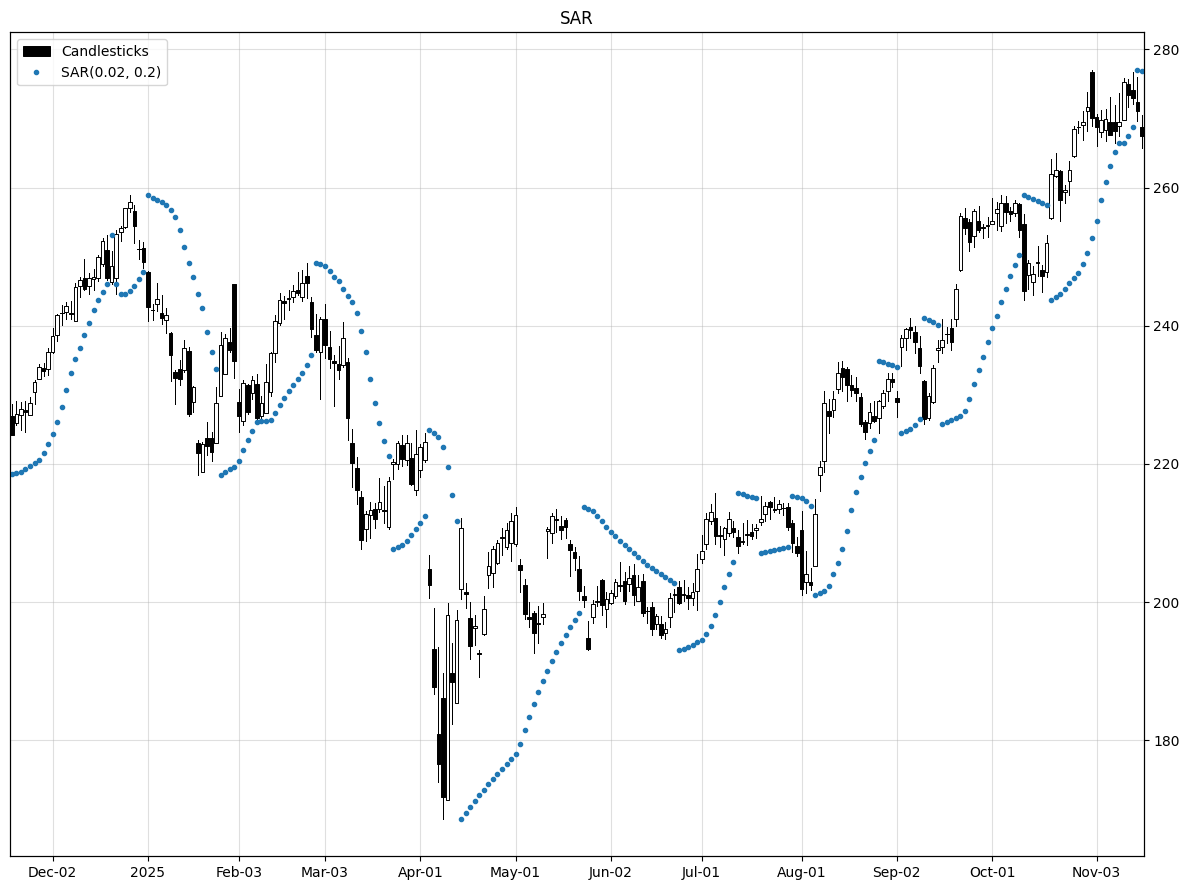

In [7]:
from mplchart.chart import Chart
from mplchart.primitives import Candlesticks


Chart(prices, title="SAR", max_bars=250).plot(
    Candlesticks(),
     SAR()
).show()


True